In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from findlay2025a import core
from findlay2025a.constants import Files

In [2]:
import warnings

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)

In [ ]:
nb = core.get_project("seahorse")
df = pd.read_parquet(nb.get_project_file(Files.EXPORTED_CONDITION_MEASURES))

In [10]:
p = sns.color_palette("Paired")
for i in np.arange(len(p))[1::2]:  # Desaturate some colors a bit
    p[i] = tuple((np.array(p[i]) + np.array(p[i - 1])) / 2)

p = {"Early.EXT.Wake": p[2], "Late.EXT.Wake": p[3]}
for c in df["condition"].unique():
    if c not in p:
        p[c] = "k"

In [11]:
def prepost_plot(
    ax: plt.Axes,
    df: pd.DataFrame,
    x: str,
    order: tuple[str, str],
    y: str,
    connect: list[str],
    line_kwargs=None,
    scatter: bool = True,
    scatter_kwargs=None,
    scatter_palette: dict[str, str] = None,
    jitter: float = 0.05,
    random_seed: int = None,
    box: bool = True,
    box_kwargs=None,
    box_palette: dict[str, str] = None,
):
    assert len(order) == 2
    if line_kwargs is None:
        line_kwargs = dict(color="grey", lw=0.5, zorder=100)
    if scatter_kwargs is None:
        scatter_kwargs = dict(color="black", s=2, zorder=100)
    if scatter_palette is not None:
        scatter_kwargs["color"] = [
            scatter_palette[order[0]],
            scatter_palette[order[1]],
        ]
    if random_seed is not None:
        np.random.seed(random_seed)
    if box_kwargs is None:
        box_kwargs = dict(
            fliersize=0,
            saturation=1.0,
            linewidth=1.0,
        )

    if box:
        sns.boxplot(
            data=df,
            x=x,
            y=y,
            orient="v",
            order=order,
            hue=x,
            palette=box_palette,
            ax=ax,
            **box_kwargs,
        )

    df0 = df.set_index([x] + connect).loc[order[0], y]
    df1 = df.set_index([x] + connect).loc[order[1], y]
    df_merged = pd.DataFrame({order[0]: df0, order[1]: df1}).dropna().reset_index()
    for i in range(len(df_merged)):
        x_jittered = [
            0 + np.random.uniform(-jitter, jitter),
            1 + np.random.uniform(-jitter, jitter),
        ]
        ax.plot(
            x_jittered,
            [df_merged.iloc[i][order[0]], df_merged.iloc[i][order[1]]],
            **line_kwargs,
        )
        if scatter:
            ax.scatter(
                x_jittered,
                [df_merged.iloc[i][order[0]], df_merged.iloc[i][order[1]]],
                **scatter_kwargs,
            )
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(order)


def faceted_prepost_plot(
    data: pd.DataFrame,
    x: str,
    order: tuple[str, str],
    y: str,
    connect: list[str],
    col: str,
    col_order: list[str],
    figsize: tuple[float, float] = None,
    prepost_kwargs=None,
):
    assert len(order) == 2
    data = data.copy()

    data = data.loc[data[x].isin(order) & data[col].isin(col_order)]
    fig, axes = plt.subplots(
        1, len(col_order), sharex=True, sharey=True, figsize=figsize
    )
    if isinstance(axes, plt.Axes):
        axes = [axes]
    for i_col, col_val in enumerate(col_order):
        ax = axes[i_col]
        ax.set_title(col_val)
        col_df = data.loc[data[col] == col_val]
        prepost_plot(ax, col_df, x, order, y, connect, **prepost_kwargs)
    axes[0].set_ylabel(y)
    return fig, axes

In [12]:
var = "Cortical.Eta"
x = "condition"
order = ("Early.EXT.Wake", "Late.EXT.Wake")
connect = ["subject", "experiment"]
pub_yticks = [-0.2, -0.4, -0.6, -0.8]

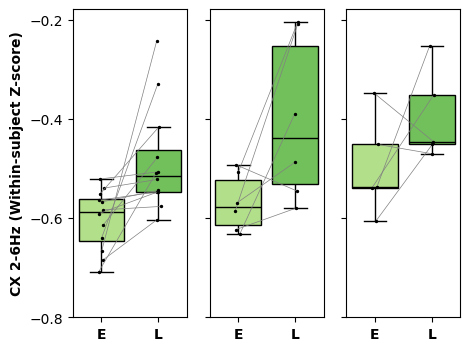

In [15]:
plot_for_pub = True

fig, axes = faceted_prepost_plot(
    df,
    x=x,
    order=order,
    y=var,
    connect=["subject"],
    col="experiment",
    col_order=("Novelty", "Locomotion", "Dual"),
    prepost_kwargs=dict(box_palette=p),
    figsize=(5, 4),
)
for ax, name in zip(axes, ["Novelty", "Locomotion", "Dual"]):
    if plot_for_pub:
        ax.set_title(None)
        ax.set_xlabel(None)
        ax.set_xticklabels(["E", "L"], weight="bold")
        ax.set_ylabel(None)
        ax.set_yticks(pub_yticks)
    else:
        ax.set_title(name)

ylabel = "CX 2-6Hz (Within-subject Z-score)"
axes[0].set_ylabel(ylabel, weight="bold")
fig.savefig(
    nb.get_project_file("figures/cx_eta_ewk_change_by_experiment.png"),
    bbox_inches="tight",
    dpi=600,
)